# Índice
1. [Importación de Dependencias](#importación-de-dependencias)
2. [Configuración del Notebook](#configuración-del-notebook)
3. [Funciones Auxiliares](#funciones-auxiliares)
    1. [getMegaDF()](#getmegadf)
    2. [enrichDF()](#enrichdf)
4. [Análisis de los Datos](#análisis-de-los-datos)
    1. [Creación del CSV Agregado](#creación-del-csv-agregado)
    2. [Enriquecimiento del DataSet](#enriquecimiento-del-dataset)


# Importación de dependencias

In [1]:
import pandas as pd
import time
import  os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from IPython.display import display
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
# Pipelines Dependencies
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import seaborn as sns
# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor


# Configuración del Notebook

In [2]:
# Cargamos los ficheros CSV en DataFrames de pandas
storeDF = pd.read_csv('./data/store.csv')
storeDataDF = pd.read_csv('./data/store-data.csv')

# Esta variable permite definir las columnas que se eliminarán del DataFrame
# que no vamos a usar en el TFM en ningún caso de uso.
# Hemos cambiado, este dato se va a usar y no se va a borrar directamente
columns_to_drop = [
    "CompetitionOpenSinceYear",
    "CompetitionDistance",
    "CompetitionOpenSinceMonth"
]


# Funciones Auxiliares
En esta sección están codificadas las funciones auxiliares que necesita el motor de evaluación.

## getMegaDF()
Esta función se encarga de obtener un Mega DataFrame (megaDF), unión de los dos CSV's en fichero y de eliminar aquellas columnas que no se usarán en ningún caso de uso del TFM
- `storeDF`: DataFrame que contiene los datos del archivo store.csv
- `storeDataDF`: DataFrame que contiene los datos del archivo store-data.csv
- `columns_to_drop`: Lista de columnas que queremos eliminar del Mega DataFrame

In [3]:
def getMegaDF(storeDF, 
              storeDataDF, 
              columns_to_drop):

    # Para poder tener todos los datos de entrada en una sola tabla 
    # mergeamos el DataFrame storeDF con el DataFrame storeDataDF 
    # por la columna Store
    megaDF = storeDF.merge(storeDataDF, on='Store')

    # Eliminamos las columnas del DataFrame mergeado que no
    # vamos a usar para la inferencia
    # megaDF = megaDF.drop(columns=columns_to_drop)
    
    # Eliminamos las filas que contienen valores nulos
    # megaDF = megaDF.dropna() ojo
    
    # Reajustamos el tipo de la columna Date a datetime
    megaDF['Date'] = pd.to_datetime(megaDF['Date'])
        
    return megaDF

# enrichDF()
Esta función la utilizaremos para enriquecer el CSV Agregado (megaDF) con nuevas columnas a partir de los datos que ya contiene y para convertir las columnas categóricas en columnas numéricas.

In [4]:

def enrichDF(sourceDF):
    
    sourceDF['Date'] = pd.to_datetime(sourceDF['Date'])  # Ensure the Date column is in datetime format
    
    # Hacemos split de la columna Date en tres columnas nuevas: SalesDay, SalesMonth y SalesYear, que
    # permiten usar como numérico la fecha en String.
    sourceDF['SalesDay'] = sourceDF['Date'].dt.day
    sourceDF['SalesMonth'] = sourceDF['Date'].dt.month
    sourceDF['SalesYear'] = sourceDF['Date'].dt.year
    
    # Mapeamos los valores categóricos de la columna PromoInterval a valores numéricos
    month_mapping = {
        None:0, 
        'Jan': 1, 
        'Feb': 2, 
        'Mar': 3, 
        'Apr': 4, 
        'May': 5, 
        'Jun': 6, 
        'Jul': 7, 
        'Aug': 8, 
        'Sept': 9, 
        'Oct': 10, 
        'Nov': 11, 
        'Dec': 12
    }
    
    # Definimos las nuevas columnas a crear para cada valor de la columna PromoInterval
    promo_interval_columns = [
        'PromoIntervalMonth1', 
        'PromoIntervalMonth2', 
        'PromoIntervalMonth3', 
        'PromoIntervalMonth4'
    ]
    
    # Convertimos a String los valores de la columna PromoInterval
    sourceDF['PromoInterval'] = \
        sourceDF['PromoInterval'].astype(str)
    
    # Hacemos split de la columna PromoInterval en cuatro columnas nuevas
    sourceDF[promo_interval_columns] = \
        sourceDF['PromoInterval'].str.split(',', expand=True)
    
    # Mapeamos los valores de las nuevas columnas a valores numéricos y los valores no existentes pasan a ser cero
    sourceDF[promo_interval_columns] = \
        sourceDF[promo_interval_columns].applymap(month_mapping.get)
    
    # Eliminamos la columna PromoInterval
    sourceDF = sourceDF.drop('PromoInterval', axis=1)
    
    # Mapeamos los valores categóricos de la columna StateHoliday a valores numéricos
    state_holiday_mapping = {
        '0':0, 
        'a':1, 
        'b':2, 
        'c':3
    }
    # Convertimos a String los valores de la columna StateHoliday
    sourceDF['StateHoliday'] = \
        sourceDF['StateHoliday'].astype(str)
    
    # Mapeamos los valores de la columna StateHoliday a valores numéricos
    sourceDF['StateHoliday'] = \
        sourceDF['StateHoliday'].map(state_holiday_mapping)

    # Mapeamos los valores categóricos de la columna StoreType a valores numéricos
    story_type_mapping = {
        'a': 1,
        'b': 2,
        'c': 3,
        'd': 4
    }

    # Convertimos a String los valores de la columna StoreType
    sourceDF['StoreType'] = \
        sourceDF['StoreType'].astype(str)
    
    # Mapeamos los valores de la columna StoreType a valores numéricos
    sourceDF['StoreType'] = \
        sourceDF['StoreType'].map(story_type_mapping)
    
    # Mapeamos los valores categóricos de la columna Assortment a valores numéricos
    assortment_mapping = {
        'a': 1,
        'b': 2,
        'c': 3
    }

    # Convertimos a String los valores de la columna Assortment
    sourceDF['Assortment'] = \
        sourceDF['Assortment'].astype(str)
    
    # Mapeamos los valores de la columna Assortment a valores numéricos
    sourceDF['Assortment'] = \
        sourceDF['Assortment'].map(assortment_mapping)
    
    # Conjuntos de columnas  con nulos e imputación de los datos con ceros por ausencia de dato
    listado_columas_con_nullos = \
        ['Promo2SinceWeek','Promo2SinceYear'] + promo_interval_columns
    for columna in listado_columas_con_nullos:
        #inserción de ceros en los datos faltantes
        sourceDF[columna] = sourceDF[columna].fillna(0)
        #conversión de todos los valores a integer
        sourceDF[columna] = sourceDF[columna].astype(int)
    
    # Rellenar la distancia de la competencia con el valor de la mediana
    sourceDF['CompetitionDistance'].fillna(sourceDF['CompetitionDistance'].median(), inplace = True)
    
    # Rellenar el mes y año de apertura de la competencia con los valores más frecuentes de las columnas, es decir, las modas de esas columnas
    sourceDF['CompetitionOpenSinceMonth'].fillna(sourceDF['CompetitionOpenSinceMonth'].mode()[0], inplace = True)
    sourceDF['CompetitionOpenSinceYear'].fillna(sourceDF['CompetitionOpenSinceYear'].mode()[0], inplace = True)

    return sourceDF

# Análisis de los Datos
## Creación del CSV Agregado
En este punto se hace el join de las 2 CSV's que conforman el DataSet de Datos y eliminamos aquellas columnas que no queremos usar.

In [5]:
megaDF = \
    getMegaDF(storeDF, 
              storeDataDF, 
              columns_to_drop)

## Exploración de los datos originales

In [6]:
# Tenemos datos históricos de ventas y conjuntos de datos de tiendas
# Primer vistazo a los datos de ventas
storeDataDF.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
# Primer vistazo al dataframe de tiendas
storeDF.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
# Información sobre el conjunto de datos de ventas
storeDataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [9]:
# Información sobre las tiendas
storeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
# Valores nulos en el dataframe de tiendas
storeDF.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

De 1115 entradas, faltan valores para las columnas:

- CompetitionDistance: distancia en metros a la tienda competidora más cercana. El gráfico de distribución nos daría una idea sobre las distancias en las que generalmente se abren las tiendas y podríamos imputar los valores en consecuencia.

- CompetitionOpenSinceMonth: da el mes aproximado en que se abrió la tienda competidora más cercana. La moda de la columna nos indicaría el mes más frecuente.

- CompetitionOpenSinceYear: da el año aproximado en que se abrió la tienda competidora más cercana. La moda de la columna nos indicaría el año más frecuente.

- Promo2SinceWeek, Promo2SinceYear y PromoInterval son NaN dondequiera que Promo2 sea 0 o Falso, como se puede ver en el primer vistazo del conjunto de datos. Se pueden reemplazar con 0.

Text(0.5, 0, 'Competition Distance Distribution Plot')

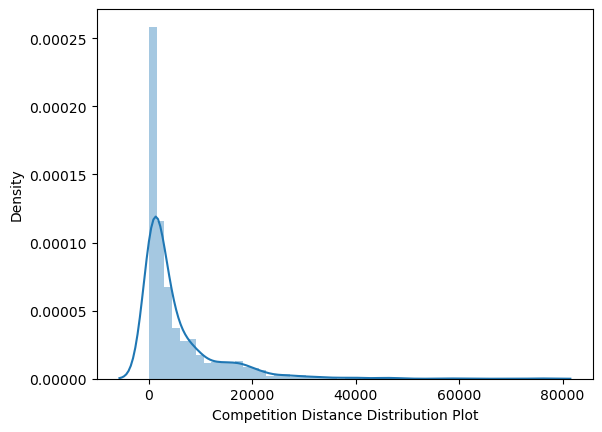

In [11]:
# Gráfico de distribución de la distancia de competencia
sns.distplot(x=storeDF['CompetitionDistance'], hist = True)
plt.xlabel('Competition Distance Distribution Plot')

Parece que la mayoría de los valores de la CompetenciaDistancia están hacia la izquierda y la distribución está sesgada hacia la derecha. La mediana es más robusta frente al efecto de los valores atípicos.

In [12]:
# Valores nulos en el dataframe de tiendas
storeDataDF.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## Enriquecimiento del DataSet
A partir del CSV Agregado en el paso anterior, en este punto y a través de la función enrichDF() se limpia y enriquecen las columnas del CSV convirtiendo las variables categóricas a variables numéricas que puedan ser interpretadas por los algoritmos de Machine Learning.

In [13]:
enrichedMegaDF = \
    enrichDF(megaDF)

In [14]:
# Las primeras cinco filas del conjunto de datos fusionado sin enriquecer
megaDF.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Promo,StateHoliday,SchoolHoliday,SalesDay,SalesMonth,SalesYear,PromoIntervalMonth1,PromoIntervalMonth2,PromoIntervalMonth3,PromoIntervalMonth4
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan,...,1,0,1,31,7,2015,NaN,0,0,0
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan,...,1,0,1,30,7,2015,NaN,0,0,0
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan,...,1,0,1,29,7,2015,NaN,0,0,0
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan,...,1,0,1,28,7,2015,NaN,0,0,0
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan,...,1,0,1,27,7,2015,NaN,0,0,0


In [15]:
# Forma del dataframe sin enriquecer
megaDF.shape

(1017209, 25)

In [16]:
# Tipos de datos dataframe sin enriquecer
megaDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  object        
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1014567 non-null  float64       
 4   CompetitionOpenSinceMonth  693861 non-null   float64       
 5   CompetitionOpenSinceYear   693861 non-null   float64       
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            509178 non-null   float64       
 8   Promo2SinceYear            509178 non-null   float64       
 9   PromoInterval              1017209 non-null  object        
 10  DayOfWeek                  1017209 non-null  int64         
 11  Date                       1017209 no

Vamos a revisar las variables categóricas.

En el análisis de datos, es importante tener en cuenta el tipo de variable categórica que se está utilizando, ya que afecta la forma en que se pueden analizar y visualizar los datos.

In [17]:
# Creando una lista de columnas categóricas
categorical_variables = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionOpenSinceMonth',
                         'CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear']

In [18]:
# Comprobando los valores únicos involucrados y si todos los valores están en tipos de datos apropiados
for col in categorical_variables:
  print(f'Unique values for {col}: {megaDF[col].unique()}')

Unique values for DayOfWeek: [5 4 3 2 1 7 6]
Unique values for Open: [1 0]
Unique values for Promo: [1 0]
Unique values for StateHoliday: ['0' 'a' 'b' 'c' 0]
Unique values for SchoolHoliday: [1 0]
Unique values for StoreType: ['c' 'a' 'd' 'b']
Unique values for Assortment: ['a' 'c' 'b']
Unique values for CompetitionOpenSinceMonth: [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
Unique values for CompetitionOpenSinceYear: [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Unique values for Promo2: [0 1]
Unique values for Promo2SinceWeek: [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Unique values for Promo2SinceYear: [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]


In [35]:
# Las primeras cinco filas del conjunto de datos fusionado con los datos enriquecidos
enrichedMegaDF.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,...,Promo,StateHoliday,SchoolHoliday,SalesDay,SalesMonth,SalesYear,PromoIntervalMonth1,PromoIntervalMonth2,PromoIntervalMonth3,PromoIntervalMonth4
0,1,3,1,1270.0,9.0,2008.0,0,0,0,5,...,1,0,1,31,7,2015,0,0,0,0
1,1,3,1,1270.0,9.0,2008.0,0,0,0,4,...,1,0,1,30,7,2015,0,0,0,0
2,1,3,1,1270.0,9.0,2008.0,0,0,0,3,...,1,0,1,29,7,2015,0,0,0,0
3,1,3,1,1270.0,9.0,2008.0,0,0,0,2,...,1,0,1,28,7,2015,0,0,0,0
4,1,3,1,1270.0,9.0,2008.0,0,0,0,1,...,1,0,1,27,7,2015,0,0,0,0


In [38]:
# Forma del dataframe enriquecido
enrichedMegaDF.shape

(1017209, 24)

In [39]:
# Tipos de datos dataframe enriquecido
enrichedMegaDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  int64         
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  float64       
 5   CompetitionOpenSinceYear   1017209 non-null  float64       
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  int32         
 8   Promo2SinceYear            1017209 non-null  int32         
 9   DayOfWeek                  1017209 non-null  object        
 10  Date                       1017209 non-null  datetime64[ns]
 11  Sales                      1017209 no

## Análisis Exploratorio de Datos EDA

El análisis exploratorio de datos es una parte crucial del análisis de datos. Implica explorar y analizar el conjunto de datos dado para encontrar patrones, tendencias y conclusiones que permitan tomar mejores decisiones relacionadas con los datos, a menudo utilizando gráficos estadísticos y otras herramientas de visualización de datos para resumir los resultados. Se utilizan bibliotecas de Python como pandas para explorar los datos y matplotlib y seaborn para visualizarlos. Incluye analizar de qué se compone nuestro conjunto de datos. Explorar variables continuas así como categóricas y su influencia en nuestra variable dependiente, las 'Ventas'.

### Hipótesis

Solo observando el encabezado del conjunto de datos y comprendiendo las características involucradas en él, podrían formularse las siguientes hipótesis:

- Existe una característica llamada "DayOfWeek" con los valores 1-7 que denotan cada día de la semana. Probablemente habría un día libre, probablemente el domingo, cuando las tiendas estarían cerradas y tendríamos ventas globales bajas.
- Los clientes tendrían una correlación positiva con las ventas.
- El tipo de tienda y la estrategia de surtido involucrada también tendrían cierto efecto en las ventas. Algunos productos de alta calidad premium generarían más ingresos.
- La promoción debería tener una correlación positiva con las ventas.
- Algunas tiendas estuvieron cerradas debido a remodelaciones, lo que generaría 0 ingresos durante ese período.
- Las tiendas están influenciadas por la estacionalidad, probablemente antes de las vacaciones las ventas serían altas.

El siguiente paso es explorar y ver de manera basada en datos sobre los factores que influyen en las ventas de las tiendas Rossmann y cómo lo hacen.

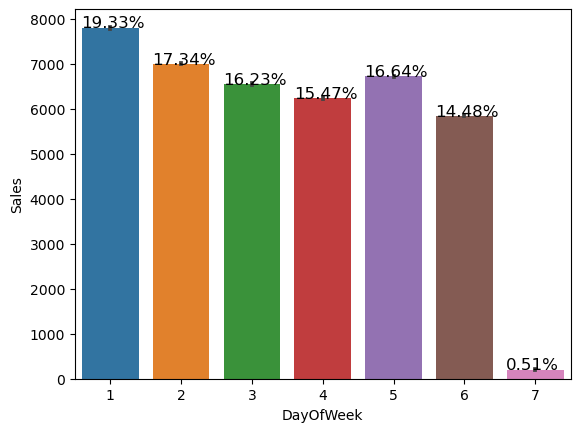

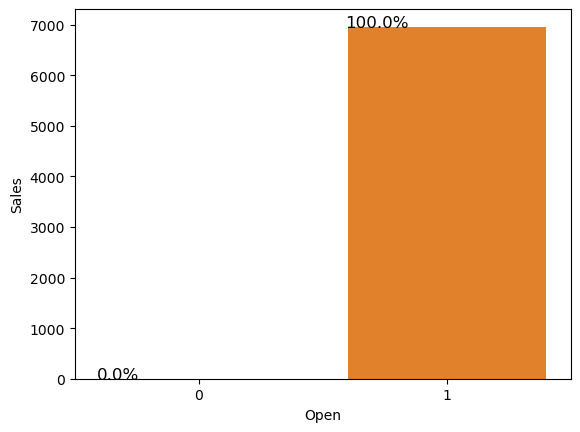

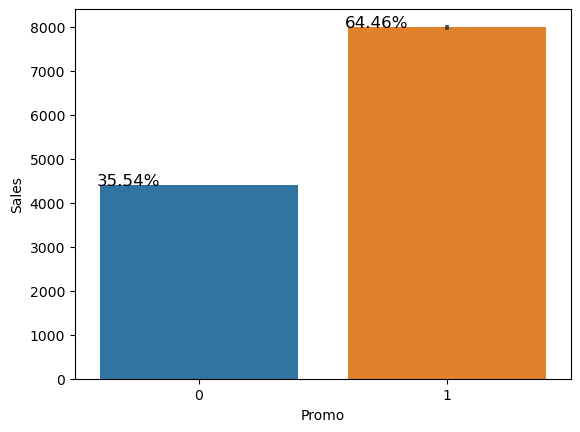

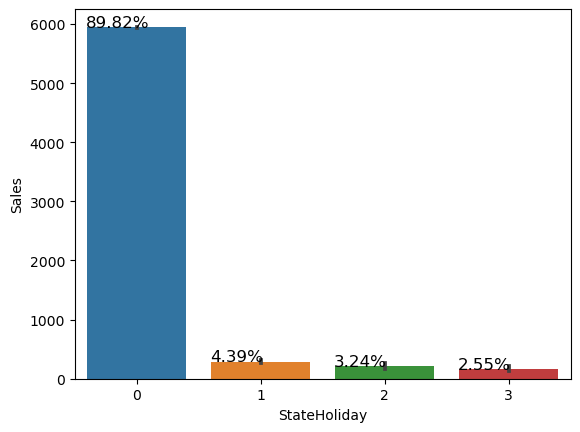

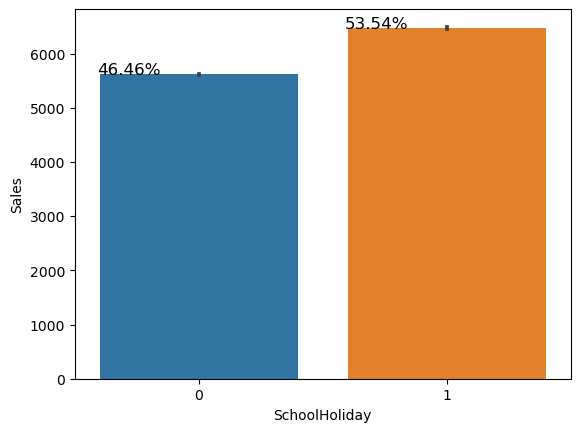

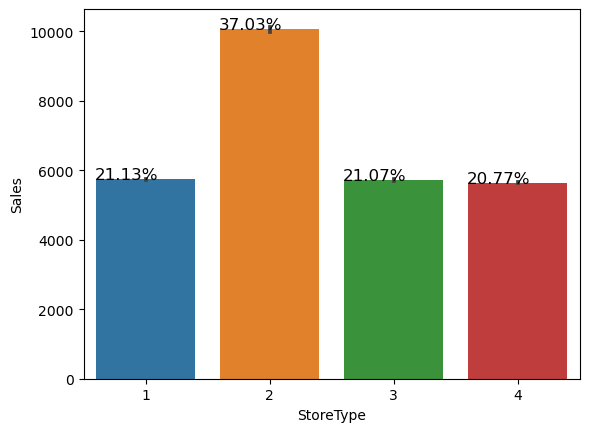

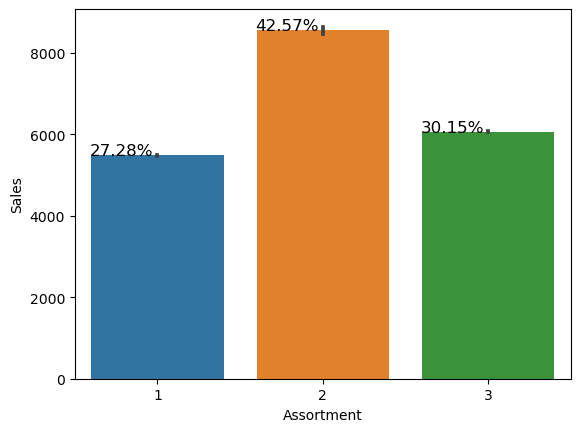

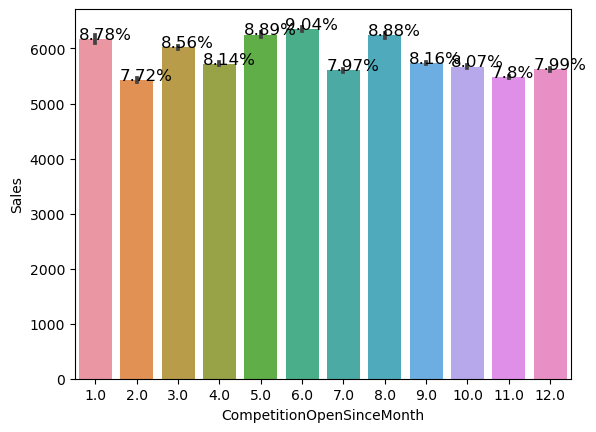

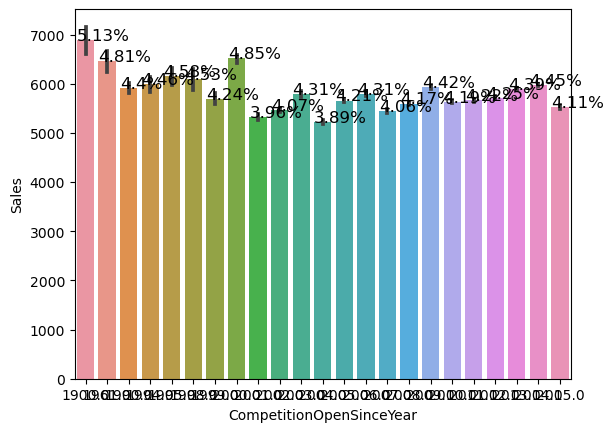

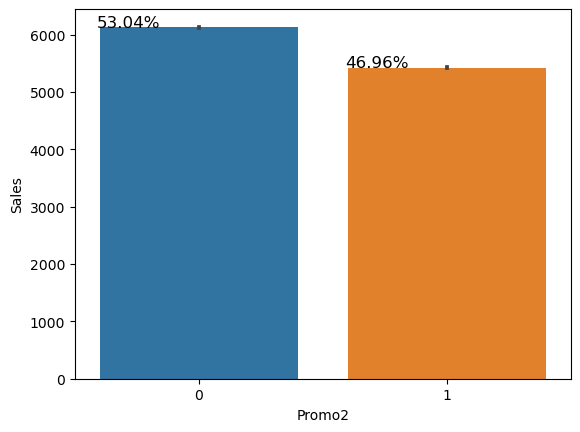

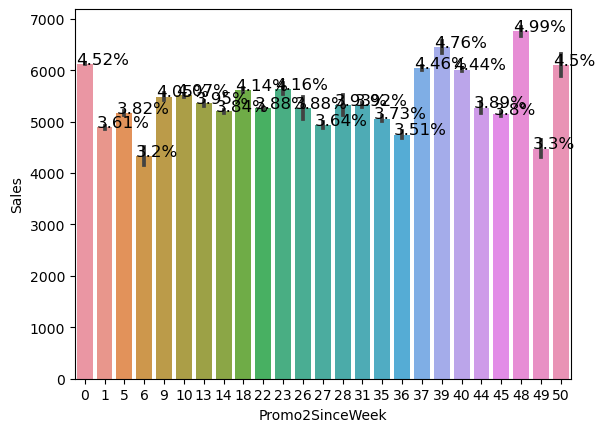

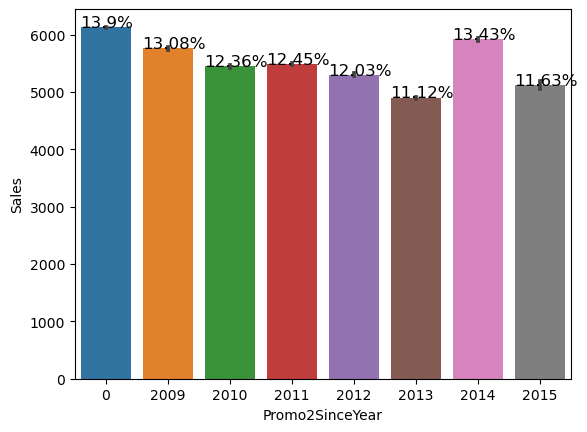

In [19]:
# Código para gráficos de barras de las variables categóricas en relación con las ventas
# Iterando sobre las variables categóricas y trazando cada una de ellas

for value in categorical_variables:
  ax = sns.barplot(x=enrichedMegaDF[value], y=enrichedMegaDF['Sales']) 
  totals = []
  for i in ax.patches: #for every patch in the barplot ax
      totals.append(i.get_height()) #append height for each patch

  total = sum(totals) #sum of each patch height for a plot

  for i in ax.patches:  
      ax.text(i.get_x() - .01, i.get_height() + .5, \
              str(round((i.get_height()/total)*100, 2))+'%', fontsize=12)  #text position and formula for percentage
  plt.show()

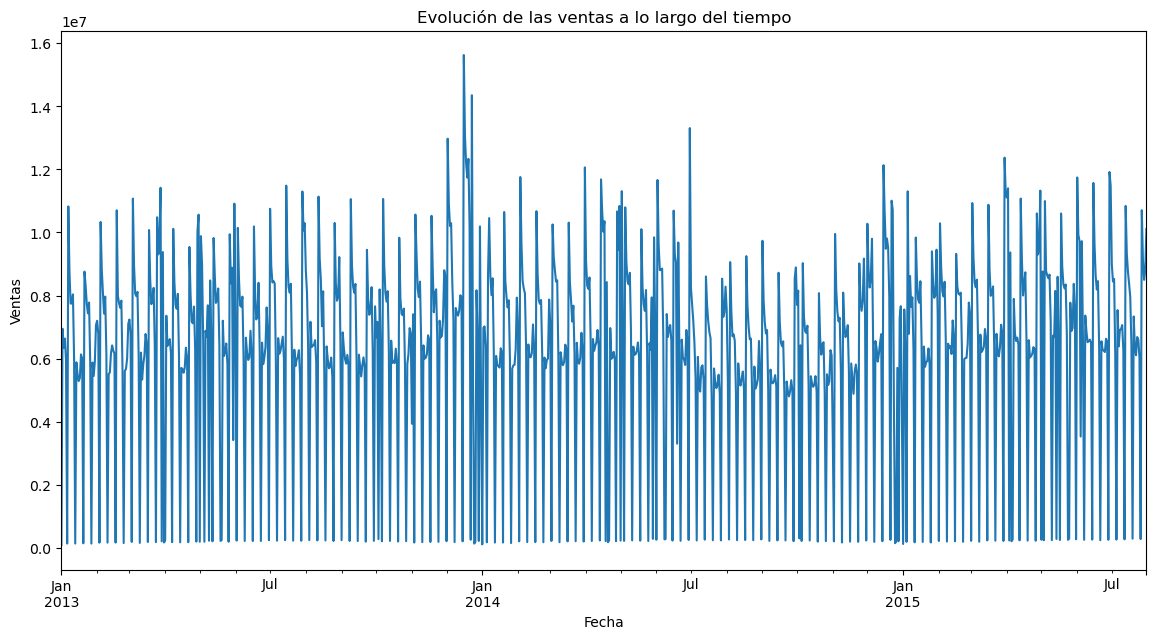

In [45]:
# Evolución de las Ventas a lo Largo del Tiempo:
# Objetivo: Analizar las tendencias de ventas a lo largo del tiempo.
# Posible conclusión: Identificar patrones estacionales, tendencias de crecimiento o declive en las ventas.

plt.figure(figsize=(14, 7))
enrichedMegaDF.groupby('Date')['Sales'].sum().plot()
plt.title('Evolución de las ventas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

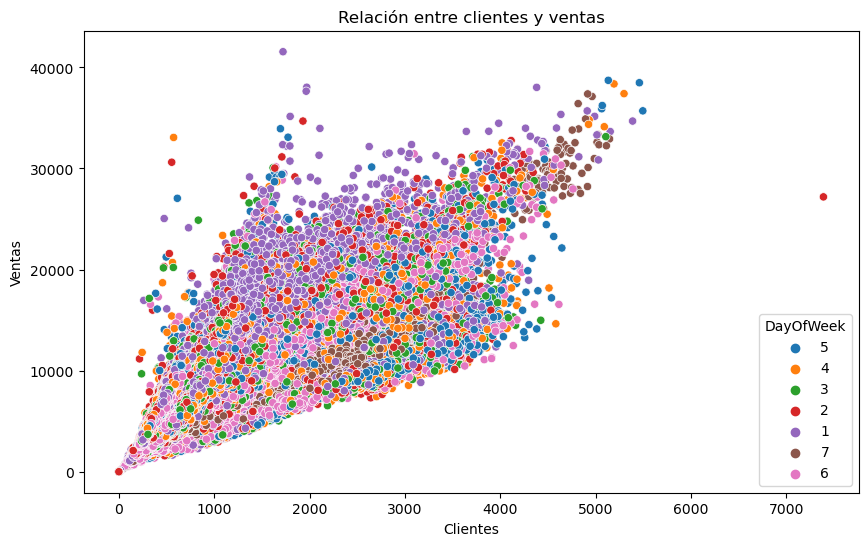

In [46]:
# Relación entre clientes y ventas:
# Objetivo: Evaluar la correlación entre el número de clientes y las ventas.
# Posible conclusión: Determinar si un mayor número de clientes siempre conduce a mayores ventas y qué tiendas son más eficientes en convertir clientes en ventas.

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Customers', y='Sales', data=enrichedMegaDF, hue="DayOfWeek")
plt.title('Relación entre clientes y ventas')
plt.xlabel('Clientes')
plt.ylabel('Ventas')
plt.show()

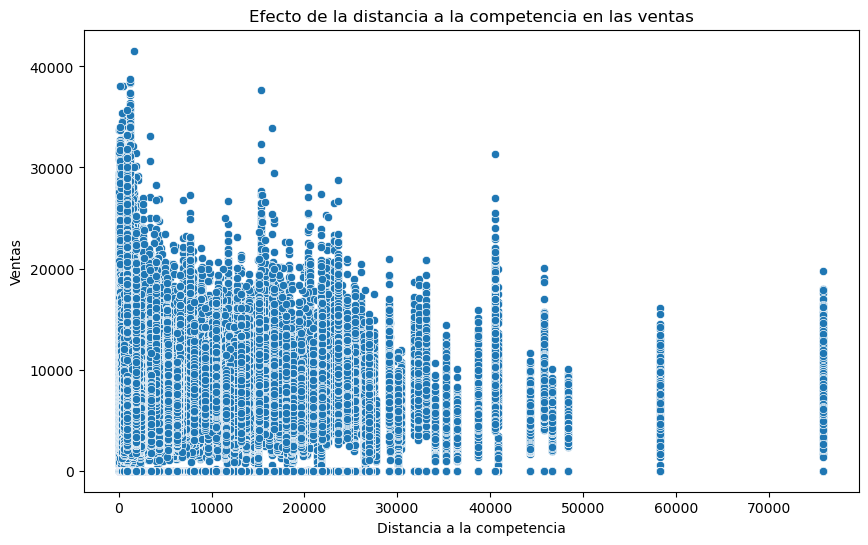

In [48]:
# Evaluación del efecto de las distancias competitivas y temporales:
# Objetivo: Investigar si la distancia y el tiempo desde la apertura de la competencia afectan las ventas.
# Posible conclusión: Determinar si las tiendas ubicadas lejos de la competencia o aquellas que han coexistido por más tiempo con la competencia tienen mejores resultados de ventas.

plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=enrichedMegaDF)
plt.title('Efecto de la distancia a la competencia en las ventas')
plt.xlabel('Distancia a la competencia')
plt.ylabel('Ventas')
plt.show()

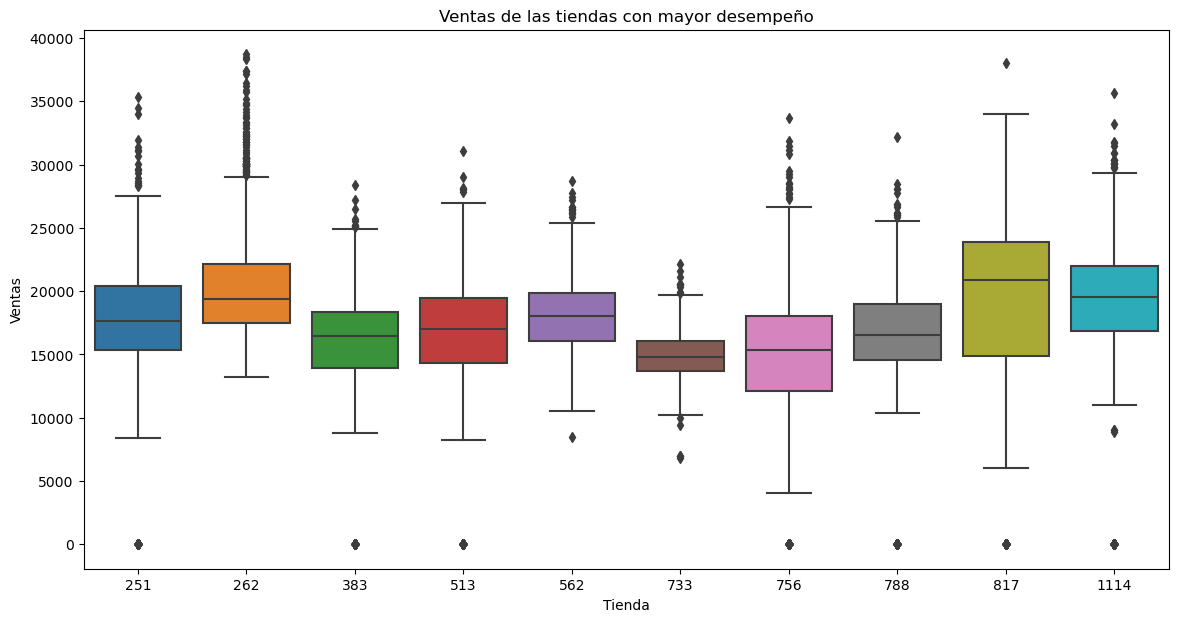

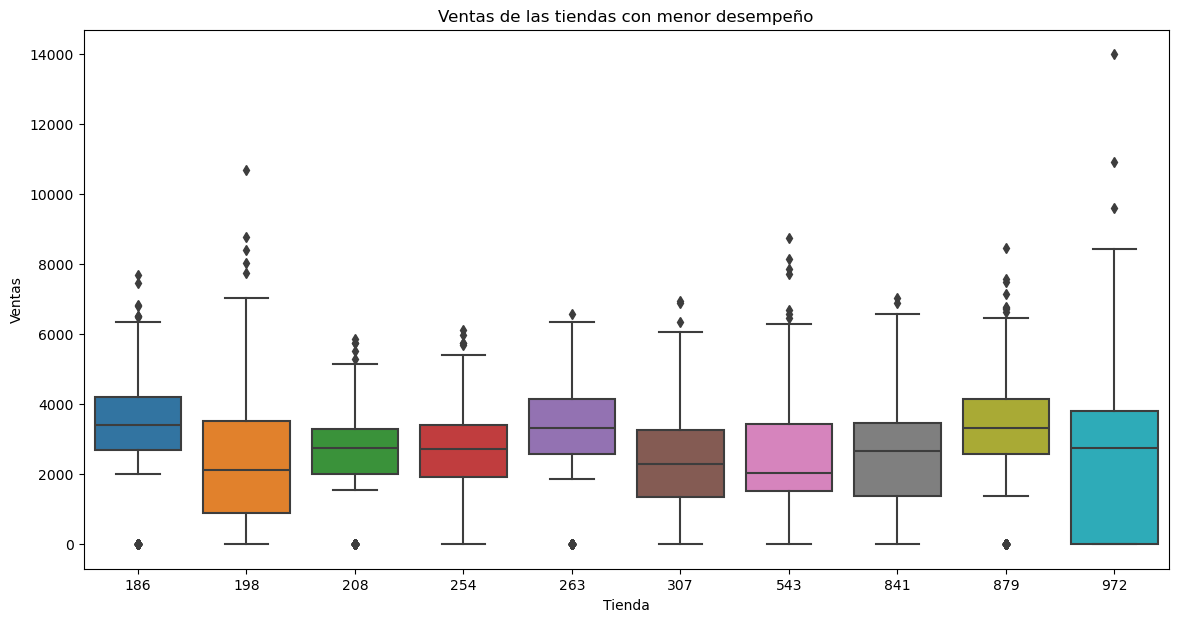

In [49]:
# Análisis de las Tiendas con Mayor y Menor Desempeño:
# Objetivo: Identificar las tiendas con las mayores y menores ventas.
# Posible conclusión: Entender las características comunes de las tiendas de alto rendimiento y las de bajo rendimiento para replicar las mejores prácticas y corregir las debilidades.

top_stores = enrichedMegaDF.groupby('Store')['Sales'].sum().nlargest(10).index
bottom_stores = enrichedMegaDF.groupby('Store')['Sales'].sum().nsmallest(10).index

plt.figure(figsize=(14, 7))
sns.boxplot(x='Store', y='Sales', data=enrichedMegaDF[enrichedMegaDF['Store'].isin(top_stores)])
plt.title('Ventas de las tiendas con mayor desempeño')
plt.xlabel('Tienda')
plt.ylabel('Ventas')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(x='Store', y='Sales', data=enrichedMegaDF[enrichedMegaDF['Store'].isin(bottom_stores)])
plt.title('Ventas de las tiendas con menor desempeño')
plt.xlabel('Tienda')
plt.ylabel('Ventas')
plt.show()

### Observación
- Hubo más ventas los lunes, probablemente porque las tiendas suelen permanecer cerradas los domingos.
- Se podría observar que la promoción conduce a más ventas.
- Normalmente, todas las tiendas, con pocas excepciones, están cerradas en días festivos estatales. Tenga en cuenta que todas las escuelas están cerradas en días festivos y fines de semana. a = día festivo estatal, b = día festivo de Pascua, c = Navidad, 0 = Ninguno. Las ventas más bajas se observaron en días festivos estatales, especialmente en Navidad.
- Más tiendas estuvieron abiertas en vacaciones escolares que en días festivos estatales y, por lo tanto, tuvieron más ventas que los días festivos estatales.
- En promedio, el tipo de tienda B tuvo las ventas más altas.
- Se observaron las ventas promedio más altas con niveles de surtido-b, que es 'extra'.
- Con Promo2, se observaron ligeramente más ventas sin ella, lo que indica que hay muchas tiendas que no participan en la promoción.

<Axes: xlabel='Open', ylabel='Sales'>

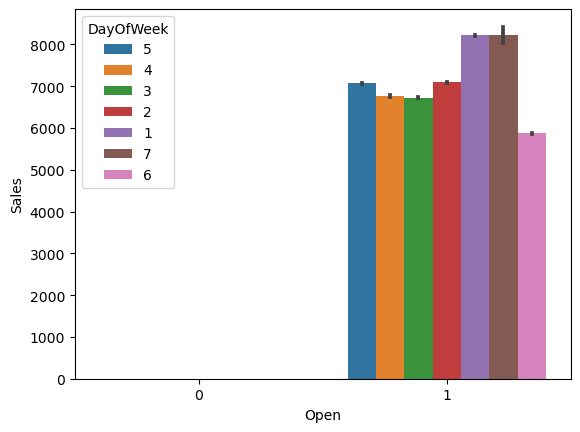

In [24]:
# Relación entre apertura y tipo de tienda
# Esto indica: Abierto sugiere si la tienda estaba abierta o cerrada por remodelación y fines de semana o días festivos.

# Convertir DayOfWeek a tipo de cadena para que funcione la gráfica (hue)
enrichedMegaDF["DayOfWeek"] = enrichedMegaDF["DayOfWeek"].astype(str)

sns.barplot(x=enrichedMegaDF["Open"],y=enrichedMegaDF['Sales'],hue=enrichedMegaDF["DayOfWeek"])

<Axes: xlabel='Open', ylabel='count'>

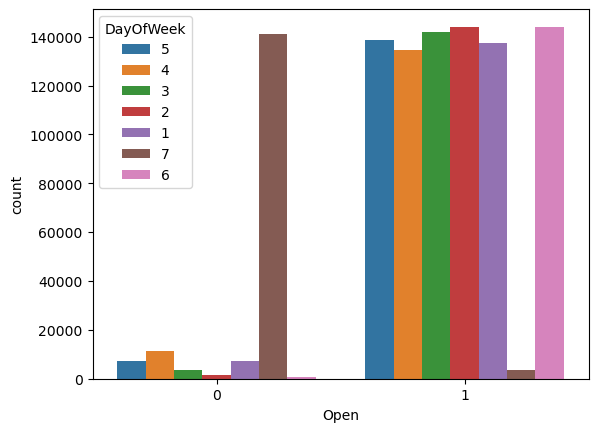

In [25]:
# Revisamos cuántas tiendas están abiertas en qué días
# Mostrar un conteo de tiendas cerradas por renovación, sugiriendo que la mayoría de las tiendas están cerradas los domingos.

sns.countplot(x=enrichedMegaDF["Open"], hue=enrichedMegaDF["DayOfWeek"])

<Axes: xlabel='StoreType', ylabel='Sales'>

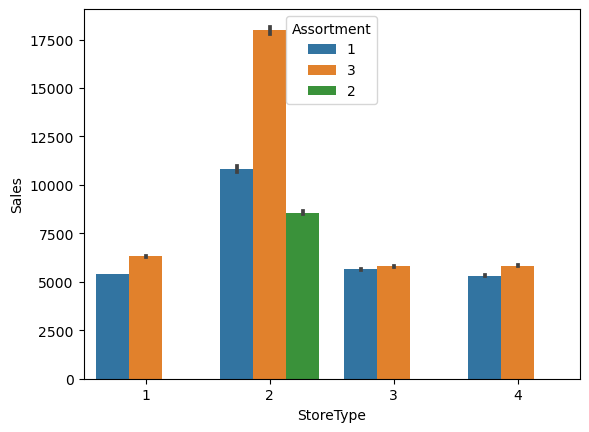

In [26]:
# Revisemos la relación entre el tipo de tienda, los niveles de surtido y las ventas

# Convertir DayOfWeek a tipo de cadena para que funcione la gráfica (hue)
enrichedMegaDF["Assortment"] = enrichedMegaDF["Assortment"].astype(str)

sns.barplot(x=enrichedMegaDF["StoreType"],y=enrichedMegaDF['Sales'],hue=enrichedMegaDF["Assortment"])

La gráfica de barras anterior muestra que los tipos de tienda a, c y d solo tienen niveles de surtido a y c. Por otro lado, el tipo de tienda b tiene los tres tipos de estrategias de surtido, lo que explica por qué las ventas promedio fueron altas para las tiendas de tipo b.

In [27]:
# Exploración del tipo de tienda y ventas
store_type = enrichedMegaDF.groupby("StoreType")["Sales","Customers"].sum().reset_index()
store_type.sort_values(["Sales","Customers"], ascending= False, inplace = True) # Ordenando en orden descendente para obtener los valores más altos
store_type

,StoreType,Sales,Customers
0,1,3165334859,363541434
3,4,1765392943,156904995
2,3,783221426,92129705
1,2,159231395,31465621


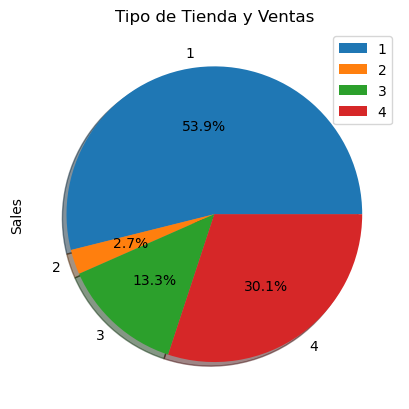

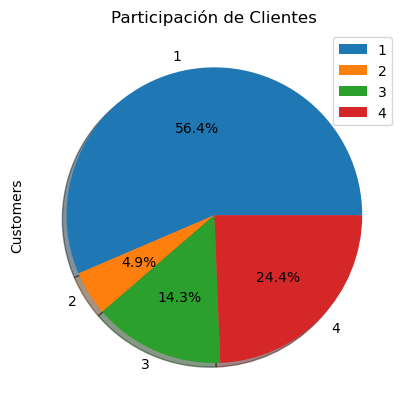

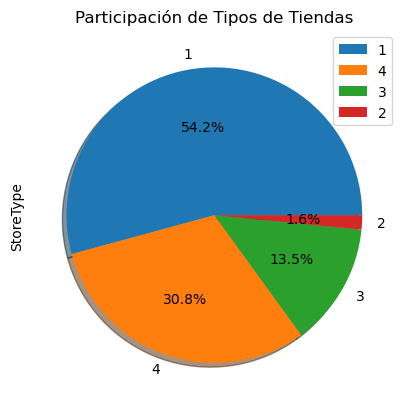

In [28]:
# Vamos a explorar el tipo de tienda y su influencia en las ventas.
enrichedMegaDF.groupby("StoreType")["Sales"].sum().plot.pie(title='Tipo de tienda y ventas', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()
# Clientes y tipo de tienda
enrichedMegaDF.groupby("StoreType")["Customers"].sum().plot.pie(title='Participación de clientes', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()
# Tipos de tienda en todo el conjunto de datos
enrichedMegaDF["StoreType"].value_counts().plot.pie(title='Participación de tipos de tiendas', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()

### Observación:
- Las ventas más elevadas corresponden al tipo de tienda 1, debido al elevado número de tiendas de este tipo. Las tiendas de tipo 1 y 3 tienen una relación entre las ventas y la cuota de clientes similares.
- La tienda de tipo 2 tiene las ventas medias y generación de ingresos por tienda más elevada, y esto se debe a que dispone de los tres tipos de surtido, tal y como se ha visto anteriormente.


In [41]:
# ventas por año
df_2013 = enrichedMegaDF[enrichedMegaDF['SalesYear']== 2013]
df_2014 = enrichedMegaDF[enrichedMegaDF['SalesYear']== 2014]
df_2015 = enrichedMegaDF[enrichedMegaDF['SalesYear']== 2015]

In [42]:
# ventas mensuales
sales_2013 = df_2013.groupby('SalesMonth')['Sales'].sum().reset_index()
sales_2014 = df_2014.groupby('SalesMonth')['Sales'].sum().reset_index()
sales_2015 = df_2015.groupby('SalesMonth')['Sales'].sum().reset_index()

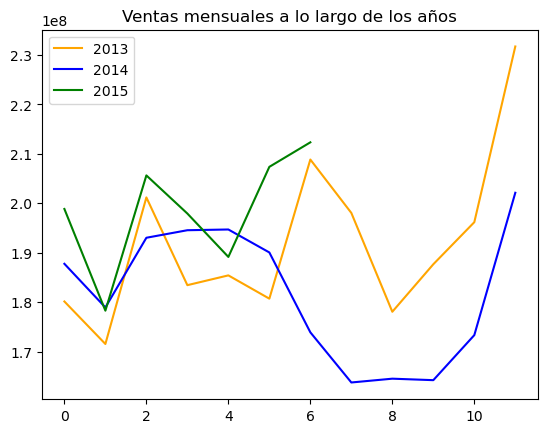

In [44]:
# gráfica
plt.plot(sales_2013.loc[:,'Sales'],label='2013',color='orange')
plt.plot(sales_2014.loc[:,'Sales'],label='2014',color='blue')
plt.plot(sales_2015.loc[:,'Sales'],label='2015',color='green')
plt.title('Ventas mensuales a lo largo de los años')
plt.legend()

### Conclusiones del Análisis Exploratorio de Datos (EDA) y Validación de Hipótesis:

- Existe una correlación positiva entre los clientes y ventas.
- Las promociones tienen un efecto positivo en las ventas.
- La mayoría de las tiendas están cerradas durante los días festivos estatales y escolares.
- Es importante tener en cuenta que hubo más tiendas abiertas en las vacaciones escolares que en el resto de los días festivos, y por lo tanto, tuvieron más ventas en estos últimos.
- Hubo más ventas los lunes, probablemente porque las tiendas suelen permanecer cerradas los domingos.
- Las tiendas de tipo 1 y 3 son bastante similares en número de venas por cliente y tienda. Al ser el mayor número de tiendas en total, obtuvieron el mayor número de ingresos generales.
- Las tiendas de tipo 2 son pocas en número que tienen mejores ventas promedio que el resto.
- Las tiendas de tipo 2 y 4 tienen más clientes por tienda y mas ventas por cliente respectivamente. Esto puede ayudar a mejorar el rendimiento de las otras tiendas revisando la estrategia de estas.
- Las tiendas de tipo 2 tiene los tres tipos de surtido y el resto solo dos. Esta diferencia puede motivo de porque las tiendas de 2 obtienen mayores ingresos.
- Al revisar como se comportan las ventas en el tiempo, se observa que las ventas aumentan hacia el final de año, lo que índice que los clientes compran más antes de vacaciones.
- Todas las tiendas muestran una estacionalidad navideña, que refuerza el punto anterior.
- Las ventas disminuyeron durante unos meses en 2014, que representa que hubo bastantes tiendas cerradas por remodelación.